In [1]:
import jax
jax.config.update("jax_enable_x64", True)

# tell JAX we are using CPU
jax.config.update('jax_platform_name', 'cpu')

# import Array and set default backend
from qiskit_dynamics.array import Array
Array.set_default_backend('jax')

from qiskit_dynamics.array import wrap

jit = wrap(jax.jit, decorator=True)

In [2]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams["font.size"] = 16

import qiskit.pulse as pulse
from qiskit.quantum_info.states import Statevector
from qiskit.quantum_info.operators import Operator

from qiskit_dynamics import Solver
from qiskit_dynamics.pulse import InstructionToSignals

## \begin{align} 
H_\text{drift} &= \frac{\omega}{2} Z\\
\nonumber \\
H_\text{drive}(t) &= \frac{r\,\Omega(t)}{2} X 
\end{align}


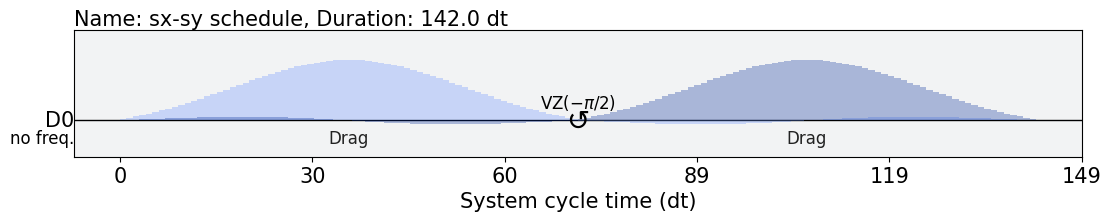

In [3]:
r = 0.1  # Strength of the Rabi-rate in GHz.

w = 5.0  # Frequency of the qubit transition in GHz.

dt = 0.222  # Sample rate of the backend in ns.

# Define gaussian envelope function to have a pi rotation.
amp = 1.0
area = 1
sig = area * 0.399128 / r / amp
T = 4 * sig
duration = int(T / dt)
beta = 2.0

# The 1.75 factor is used to approximately get a sx gate.
# Further "calibration" could be done to refine the pulse amplitude.
with pulse.build(name="sx-sy schedule") as xp:
    """
    We begin by creating a pulse schedule with a sx gate followed by a
    phase shift on the drive so that the following pulse creates a sy rotation
    """
    pulse.play(pulse.Drag(duration, amp / 1.75, sig / dt, beta), pulse.DriveChannel(0))
    pulse.shift_phase(np.pi / 2, pulse.DriveChannel(0))
    pulse.play(pulse.Drag(duration, amp / 1.75, sig / dt, beta), pulse.DriveChannel(0))

xp.draw()

In [4]:
converter = InstructionToSignals(dt, carriers={"d0": w})
signals = converter.get_signals(xp)

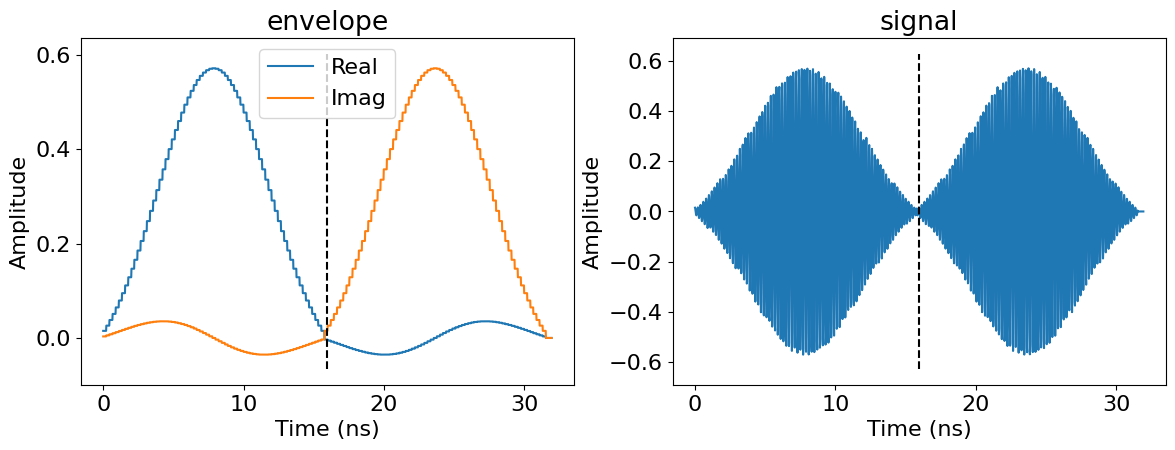

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4.5))
for ax, title in zip(axs, ["envelope", "signal"]):
    signals[0].draw(0, 2 * T, 2000, title, axis=ax)
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)
    ax.vlines(T, ax.get_ylim()[0], ax.get_ylim()[1], "k", linestyle="dashed")

In [6]:
# construct operators
X = Operator.from_label("X")
Z = Operator.from_label("Z")

drift = 2 * np.pi * w * Z / 2
operators = [2 * np.pi * r * X / 2]

# construct the solver
hamiltonian_solver = Solver(
    static_hamiltonian=drift,
    hamiltonian_operators=operators,
    rotating_frame=drift,
    rwa_cutoff_freq=2 * 5.0,
    hamiltonian_channels=["d0"],
    channel_carrier_freqs={"d0": w},
    dt=dt,
)

In [7]:
# Start the qubit in its ground state.
y0 = jax.numpy.array([1.0, 0.0])

def solve(T_mul):
    result = hamiltonian_solver.solve(t_span=[0., T_mul], y0=y0, signals=signals, t_eval=np.linspace(0, T_mul, 100), method='jax_odeint')
    return result.t, result.y

fast_solve = jit(solve, static_argnames='T_mul')
# sol = fast_solve(5*T)

# %time sol = hamiltonian_solver.solve(t_span=[0., 5*T], y0=y0, signals=xp, atol=1e-8, rtol=1e-8)

In [8]:
sol = fast_solve(5*T)


In [9]:
def plot_populations(sol):
    pop0 = [(np.abs(psi)**2)[0] for psi in sol[1]]
    pop1 = [(np.abs(psi)**2)[1] for psi in sol[1]]

    fig = plt.figure(figsize=(8, 5))
    plt.plot(sol[0], pop0, lw=3, label="Population in |0>")
    plt.plot(sol[0], pop1, lw=3, label="Population in |1>")
    plt.xlabel("Time (ns)")
    plt.ylabel("Population")
    plt.legend(frameon=False)
    plt.ylim([0, 1.05])
#     plt.xlim([0, 2*T])
    plt.vlines(T, 0, 1.05, "k", linestyle="dashed")

In [ ]:
plot_populations(sol)

In [ ]:
%timeit _ = solve(5*T)
%timeit _ = fast_solve(5*T)